In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_set = pd.read_csv('~/Downloads/2025datathon/train.csv')
test_set = pd.read_csv('~/Downloads/2025datathon/test.csv')

int64: 2 : ['id', 'Depression']
object: 10 : ['Name', 'Gender', 'City', 'Working Professional or Student', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
float64: 8 : ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 

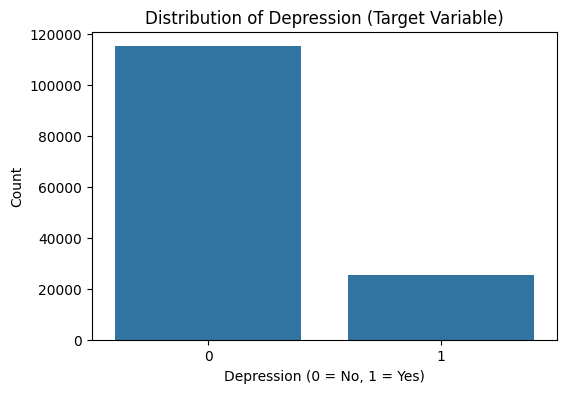

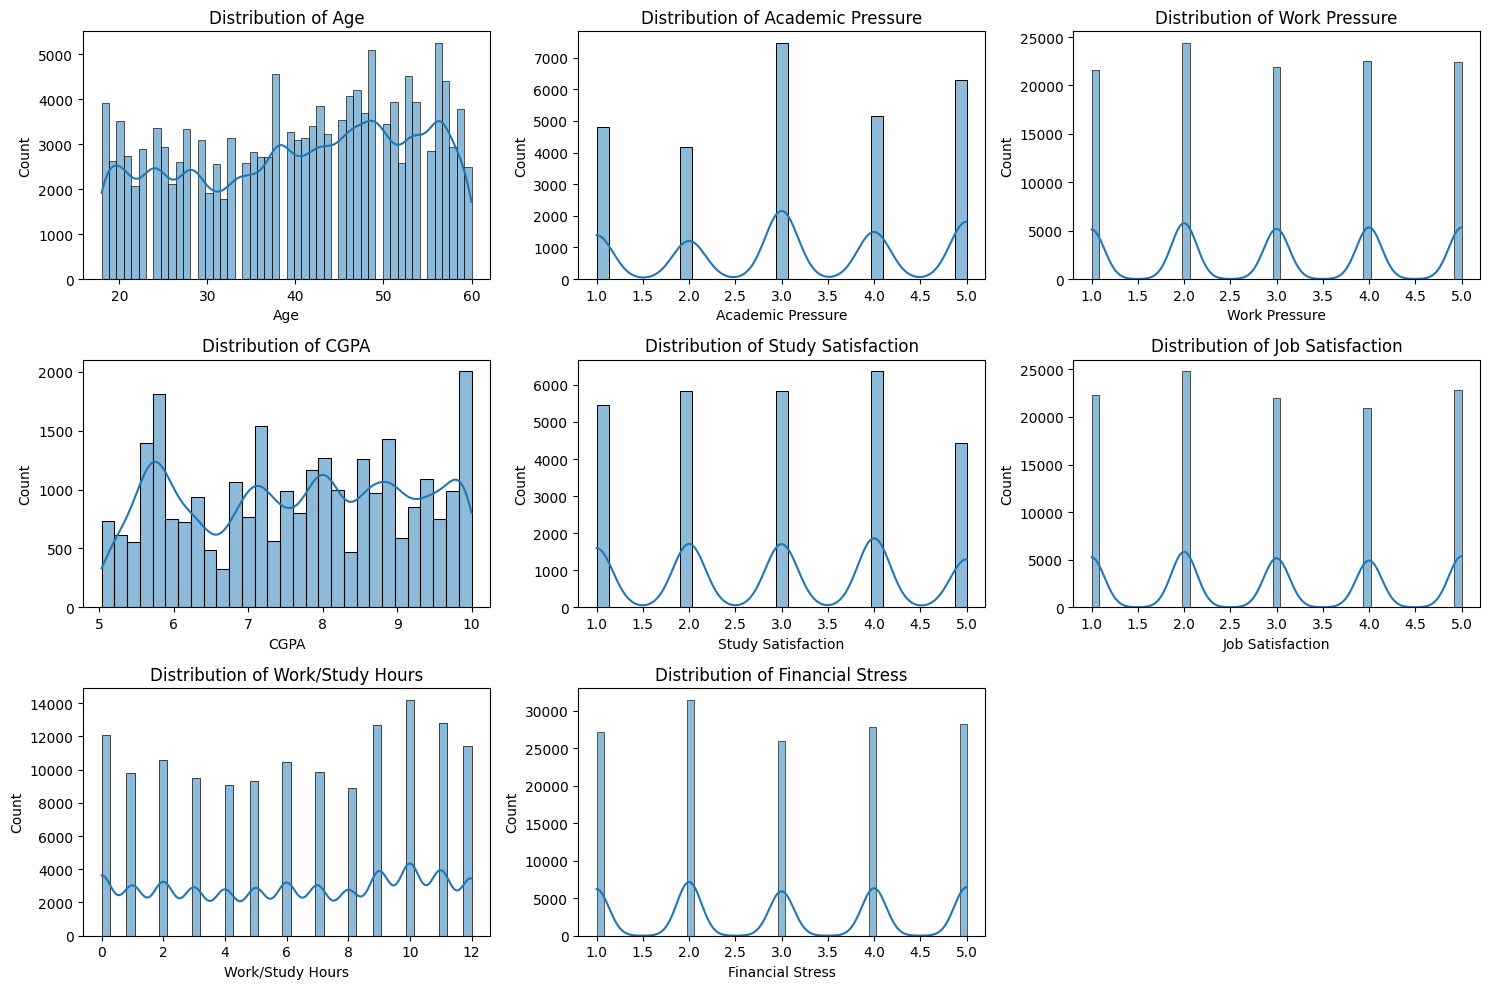

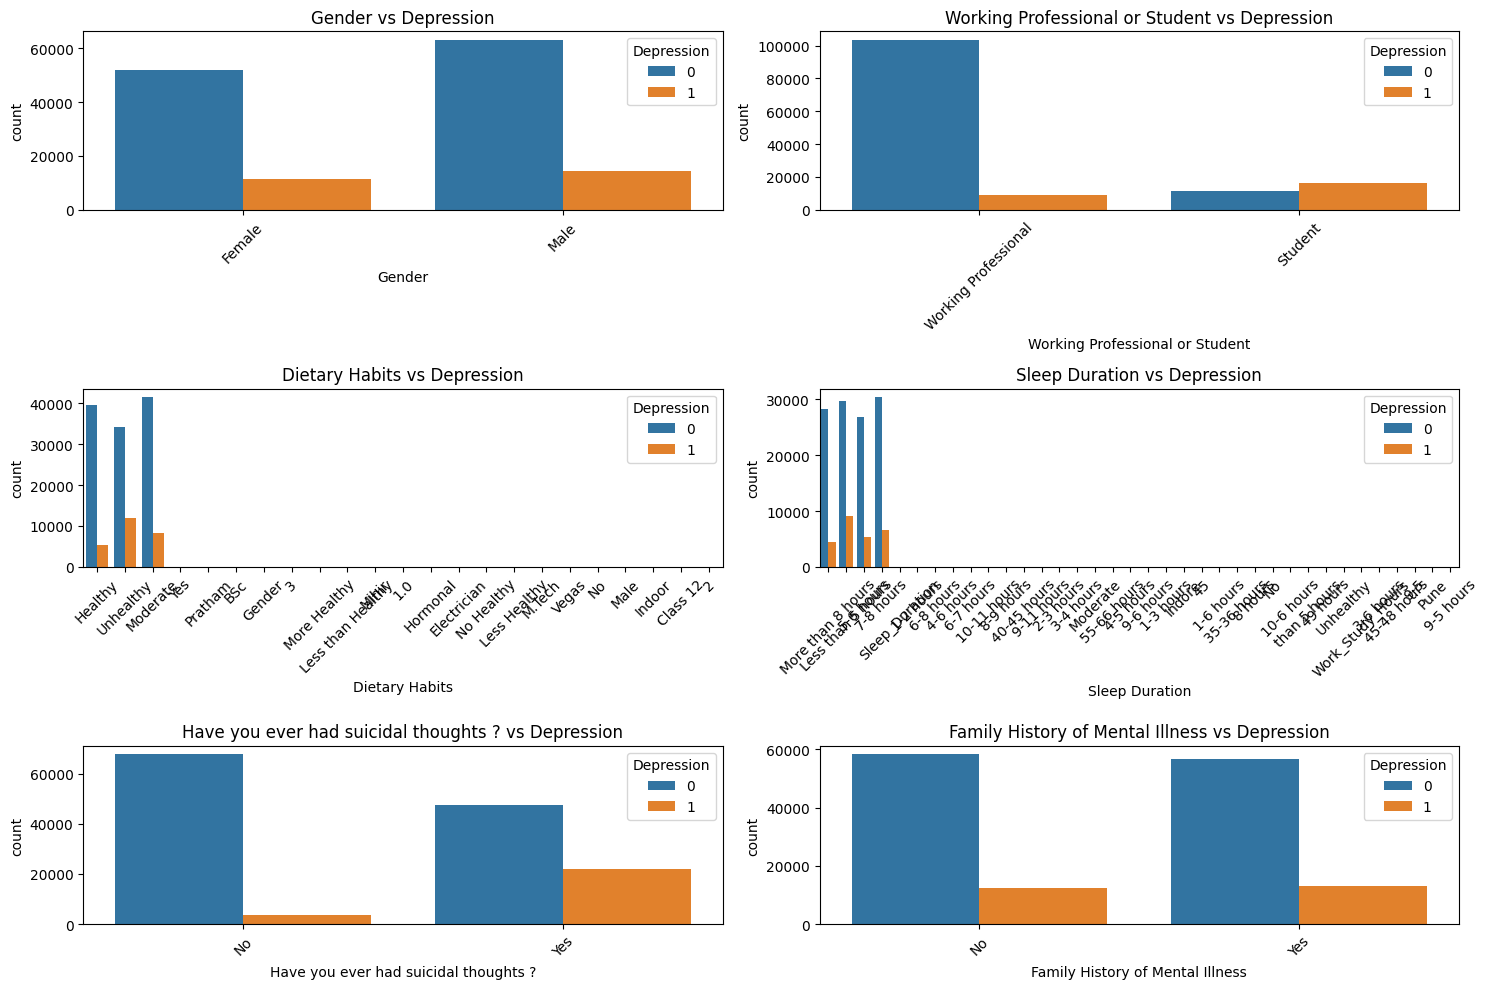

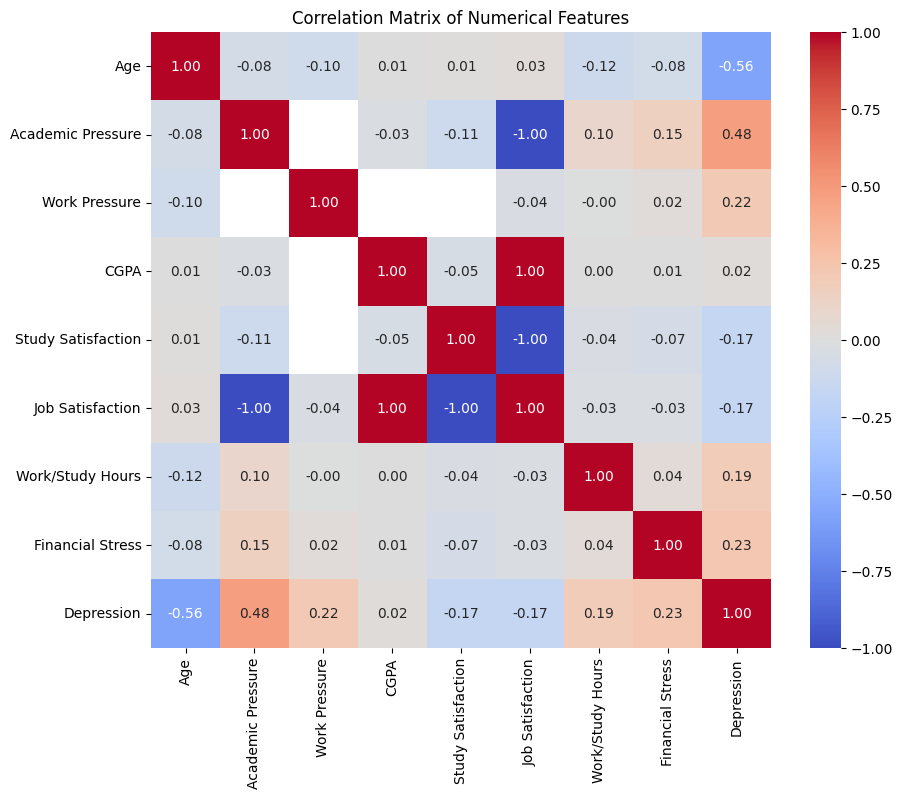

In [2]:

# data set check
def check_data_type(df=None):
    # Create a dictionary of column names and their data types
    dic = {col: df[col].dtype for col in df.columns}
    dic = {k: [col for col, v in dic.items() if v == k] for k in set(dic.values())}
    print("\n".join(f"{k}: {len(v)} : {v}" for k, v in dic.items()))

# Basic information about the dataset
check_data_type(train_set)
print("Dataset Info:")
print(train_set.info())

#eheck out the missing value count and its percentage of the totoal count 
print(f"\nMissing Values:{train_set.isnull().sum()}") # and {train_set.isnull().sum()/len(train_set)}")

# Summary statistics for numerical features
print("\nSummary Statistics for Numerical Features:")
print(train_set.describe())


# Visualize the distribution of the target variable (Depression)
plt.figure(figsize=(6, 4))
sns.countplot(x='Depression', data=train_set)
plt.title('Distribution of Depression (Target Variable)')
plt.xlabel('Depression (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Visualize numerical features' distributions
numerical_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
                  'Job Satisfaction', 'Work/Study Hours', 'Financial Stress']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(train_set[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Visualize categorical features
categorical_cols = ['Gender', 'Working Professional or Student', 'Dietary Habits', 
                    'Sleep Duration', 'Have you ever had suicidal thoughts ?', 
                    'Family History of Mental Illness']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, hue='Depression', data=train_set)
    plt.title(f'{col} vs Depression')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
correlation_matrix = train_set[numerical_cols + ['Depression']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [3]:
%pip install category_encoders

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder
import numpy as np

# Preprocessing function
def preprocess_data(df, is_training=True, encoder=None, scaler=None):
    # Create interaction term
    df['Age_WorkPressure'] = df['Age'] * df['Work Pressure']
    
    # Map binary variables
    binary_mapping = {
        'Male': 1, 'Female': 0,
        'Working Professional': 1, 'Student': 0,
        'Yes': 1, 'No': 0
    }
    for col in ['Gender', 'Working Professional or Student', 
                'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']:
        df[col] = df[col].map(binary_mapping)
    
    # Fill missing values
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col] = df[col].fillna(df[col].mean()) # 수치형 결측치를 평균으로 대치 
        else:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # Target encoding for categorical features using target, 'Depression'
    categorical_cols = ['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree']
    if is_training:
        encoder = TargetEncoder(cols=categorical_cols)
        df[categorical_cols] = encoder.fit_transform(df[categorical_cols], df['Depression'])
    else:
        df[categorical_cols] = encoder.transform(df[categorical_cols])
    
    # Drop unnecessary columns    
    drop_cols = ['Name','id'] # option, 'Name'컬럼 유지 방법 
    df = df.drop([col for col in drop_cols if col in df.columns], axis=1)
    
    # Scale numerical features
    numerical_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
                      'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Age_WorkPressure'] + categorical_cols
    if is_training:
        scaler = StandardScaler()
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    else:
        df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    if is_training:
        y = df['Depression']
        X = df.drop('Depression', axis=1)
        return X, y, encoder, scaler
    return df, encoder, scaler

test_ids = test_set['id']

# Preprocess training and test data
X, y, encoder, scaler = preprocess_data(train_set, is_training=True)
X_submission, _, _ = preprocess_data(test_set, is_training=False, encoder=encoder, scaler=scaler)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y.astype(int), test_size=0.2, random_state=42)

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


/Users/hb/miniconda3/envs/moduenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hb/miniconda3/envs/moduenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hb/miniconda3/envs/moduenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/hb/miniconda3/envs/moduenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Paramet


XGBoost Performance on Validation Data:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     22986
           1       0.84      0.81      0.83      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140


Model Comparison:
         CV Accuracy (Mean)  CV Accuracy (Std)  Validation Accuracy  \
XGBoost            0.939028           0.001845             0.938166   

         Validation F1-Score  
XGBoost             0.828301  


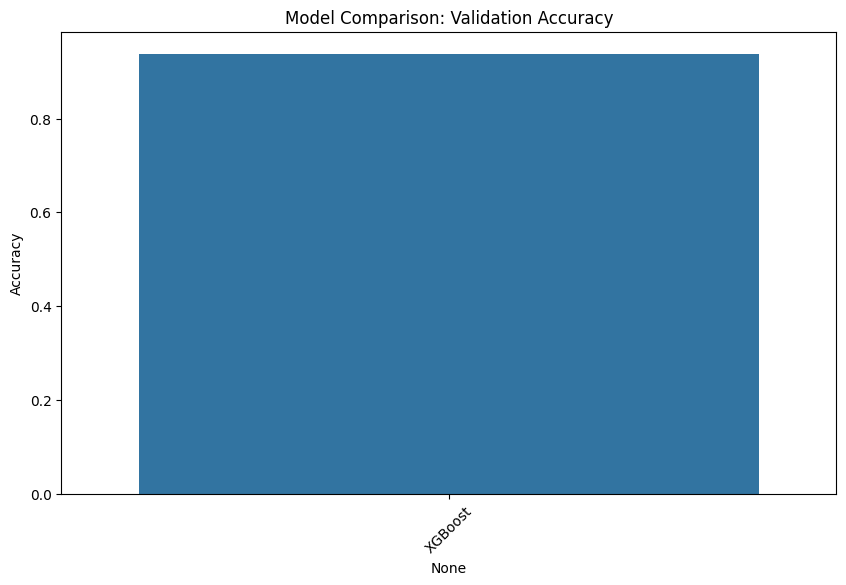

In [4]:
%pip install catboost

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

# Define models
models = {
    #'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    #'XGBoost': XGBClassifier(random_state=42, tree_method='hist', device='cuda'),
    'XGBoost': XGBClassifier(
    n_estimators=100,       # 트리 개수 (적당함)
    max_depth=4,            # 과적합 방지용 적당한 깊이
    learning_rate=0.1,      # 기본 학습률
    subsample=0.8,          # 전체 샘플 중 일부만 사용 → 일반화 성능↑
    colsample_bytree=0.8,   # 피처 중 일부만 사용 → 과적합 방지
    use_label_encoder=False,
    eval_metric='logloss',  # 분류 문제의 표준 평가지표
    random_state=42,
    n_jobs=-1               # 병렬 처리
    ),
    #'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1),
    #CatBoost': CatBoostClassifier(random_state=42, verbose=0)
}


# Evaluate models using cross-validation
results = {}
for name, model in models.items():
    # Drop 'Name' column for training and validation
    #X_train_no_name = X_train.drop(columns=['Name'])
    #X_val_no_name = X_val.drop(columns=['Name'])
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    results[name] = {
        'CV Accuracy (Mean)': cv_scores.mean(),
        'CV Accuracy (Std)': cv_scores.std(),
        'Validation Accuracy': accuracy,
        'Validation F1-Score': f1
    }
    
    # Print classification report
    print(f"\n{name} Performance on Validation Data:")
    print(classification_report(y_val, y_pred))

# Display results in a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Visualize model performance
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df.index, y=results_df['Validation Accuracy'])
plt.title('Model Comparison: Validation Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Select the best model based on validation accuracy
best_model_name = results_df['Validation Accuracy'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

# Train the best model on the full training data
best_model.fit(X, y.astype(int))

# Predict on test set

predictions = best_model.predict(X_submission)

# Create submission file
submission = pd.DataFrame({'id': test_ids, 'Depression': predictions})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")


Best Model: XGBoost


/Users/hb/miniconda3/envs/moduenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [22:24:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Submission file created: submission.csv
